In [1]:
from collections import namedtuple
import itertools

In [24]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.distributions import multivariate_normal

In [3]:
from typing import Tuple, List

In [4]:
import numpy as np
import matplotlib.pyplot as plt

The inference algorithm:
    
Parameters: $\phi$ variational, $\theta$ generative
    
while not converged do:
        
$\quad \text{x = {Get mini batch}}\\
\quad z_0 ~ q_0(\cdot | x)\\
\quad z_K = f_K( ... f_1(z_0) )\\
\quad F(x) \approx F(x, z_K)\\
\quad \Delta \theta \propto - \nabla_\theta F(x)\\
\quad \Delta \phi \propto - \nabla_\phi F(x)$

In [5]:
class Transformation:
    
    def __init__(self):
        self.training = None
        self.log_det = None
        
    @property
    def training(self):
        return self._training
    
    @training.setter
    def training(self, enable:bool):
        if not enable:
            self.log_det = None
        self._training = enable
    
    def forward(self, zi, params):
        if self.training:
            self.log_det = torch.log( self.det( zi, params ).squeeze() + 1e-7 )
        return self.transform( zi, params )
    
    def get_num_params(self):
        return 0
    
    
class PlanarTransformation(Transformation):
    
    def __init__(self, dim:int, u:list=None, w:list=None, b:list=None, training:bool=True):
        
        self.dim = dim
        self.h = nn.Tanh()
        self.training = training
        
    def get_num_params(self):
        return self.dim * 2 + 1
    
    def transform(self, z, params):
#         if torch.dot(self.w.data.squeeze(), self.u.data.squeeze()) < -1:
#             print( "adjusting u")
#             dotwu = torch.dot( self.w.data.squeeze(), self.u.data.squeeze() )
#             self.u.data = self.u + ( -1 + torch.log( 1 + torch.exp( dotwu ) ) - dotwu ) \
#                             * self.w.data / torch.sqrt( torch.dot( self.w.data.squeeze(), self.w.data.squeeze() ) )
        return z + params[self.dim:-1].unsqueeze(0) * self.h( F.linear(z, params[:self.dim].unsqueeze(0), params[-1]) )
    
    def h_deriv(self, x):
        ff = self.h( x )
        return 1 - ff * ff
    
    def psi(self, z, params):
        return self.h_deriv( F.linear(z, params[:self.dim].unsqueeze(0), params[-1]) ) * params[:self.dim].unsqueeze(0)
    
    def det(self, z, params):
        return ( 1 + torch.mm( self.psi(z, params), params[self.dim:-1].unsqueeze(0).t() ) ).abs()


class RadialTransformation(Transformation):
    
    def __init__(self, dim:int, z0=None, alpha=None, beta=None, training:bool=True):
        
        self.dim = dim
        self.training = training
        
    def get_num_params(self):
        return self.dim + 2
        
    def transform(self, z, params):
#         if self.beta < -self.alpha:
#             print( "adjusting beta")
#             self.beta.data = -self.alpha + torch.log( 1 + torch.exp( self.beta ) )
        r = torch.norm( ( z - params[:self.dim].unsqueeze(0) ), p=2, dim=1, keepdim=True )
        return z + params[-1] * ( self.h( r, params[-2] ) * (z - params[:self.dim].unsqueeze(0)) )
    
    def h(self, r, alpha):
        return 1 / (alpha + r)
    
    def h_deriv(self, r, alpha):
        ff = self.h( r, alpha )
        return - ff * ff
    
    def det(self, z, params):
        r = torch.norm( ( z - params[:self.dim].unsqueeze(0) ), p=2, dim=1, keepdim=True )
        tmp = 1 + params[-1] * self.h( r, params[-2] )
        return torch.clamp(tmp.pow(self.dim - 1) * (tmp + params[-1] * self.h_deriv(r, params[-2]) * r), min=1e-7)
    
class NormalizingFlow:
    
    def __init__( self, transformation, dim:int, K:int, transformations=None ):
        self.K = K
        self.dim = dim
        
        if transformations is None:
            transformations = [ transformation( dim ) for i in range( K ) ]
        self.flow = transformations
        self.nParams = self.flow[0].get_num_params()
        
    def get_last_log_det(self):
        return self.flow[-1].log_det
    
    def get_sum_log_det(self):
        ret = 0
        for trans in self.flow:
            ret += trans.log_det
        return ret
        
    def forward( self, z, params ):
        for i, transf in enumerate( self.flow ):
            z = transf.forward(z, params[i])
        return z

In [13]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=False)

In [14]:
# a large batch will be used to compute average flow parameters after training
large_batch = []
for i, (data, _) in enumerate(train_loader):
    if i > 1000:
        break
    large_batch.append(data)
large_batch = torch.cat(large_batch)

In [21]:
class VariationalAutoencoderNormalizingFlow(nn.Module):
    def __init__(self, flow_transform, flow_latent, flow_len):
        super(VariationalAutoencoderNormalizingFlow, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.flow = NormalizingFlow(flow_transform, flow_latent, flow_len )
        self.fc23 = nn.Linear(400, self.flow.nParams * flow_len )
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1), self.fc23(h1).mean(dim=0).chunk(self.flow.K, dim=0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar, params = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        z = self.flow.forward(z, params)
        return self.decode(z), mu, logvar

In [65]:
def plot_image(tensor, title, figsize=None, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.permute(1, 2, 0).cpu().numpy()
    fig_height, fig_width, _ = ndarr.shape
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(ndarr)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()
    plt.close()

In [69]:
device = "cpu"
model = VariationalAutoencoderNormalizingFlow(PlanarTransformation, 20, 8)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_VAENF(recon_x, x, mu, logvar, sum_log_det):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    KLD = KLD / x.size(0) - sum_log_det.mean()  # mean over batch

    return BCE + KLD

def train_VAENF(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        sum_log_det = model.flow.get_sum_log_det()
        loss = loss_function_VAENF(recon_batch, data, mu, logvar, sum_log_det)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test_VAENF(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            sum_log_det = model.flow.get_sum_log_det()
            test_loss += loss_function_VAENF(recon_batch, data, mu, logvar, sum_log_det).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(100, 1, 28, 28)[:n]])
                plot_image(comparison.cpu(),
                         'VAENF reconstruction K=' + str(model.flow.K) + " epoch=" + str(epoch), figsize=[6, 6], padding=0, nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.959102
====> Epoch: 1 Average loss: 146.8153


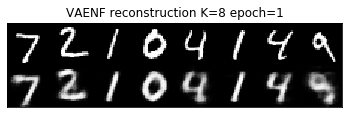

====> Test set loss: 124.2419


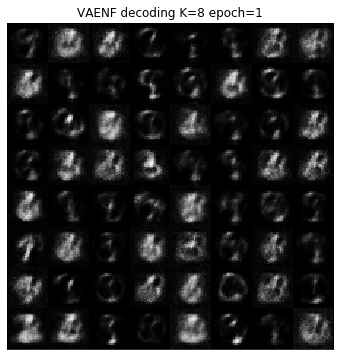

Train Epoch: 2 [0/60000 (0%)]	Loss: 115.365576
====> Epoch: 2 Average loss: 101.2075


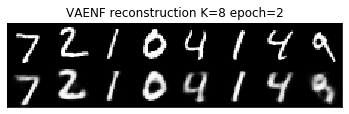

====> Test set loss: 99.4088


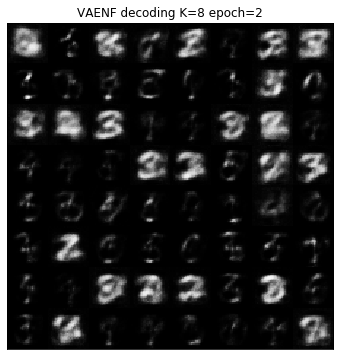

Train Epoch: 3 [0/60000 (0%)]	Loss: 95.876260
====> Epoch: 3 Average loss: 98.2013


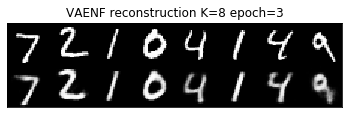

====> Test set loss: 91.8359


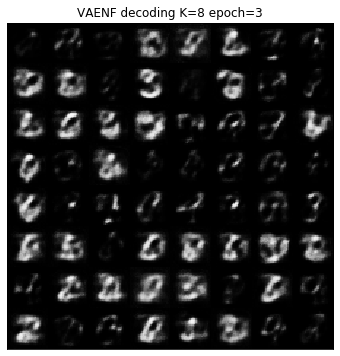

Train Epoch: 4 [0/60000 (0%)]	Loss: 88.496689
====> Epoch: 4 Average loss: 95.8787


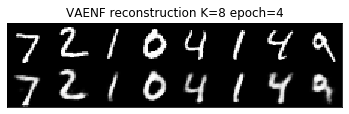

====> Test set loss: 105.4471


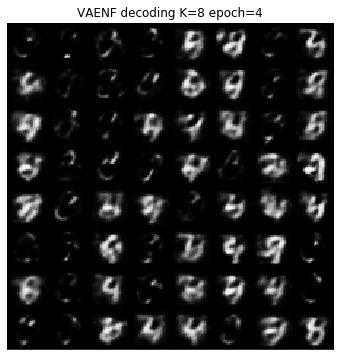

Train Epoch: 5 [0/60000 (0%)]	Loss: 104.410967
====> Epoch: 5 Average loss: 91.0702


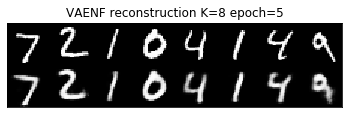

====> Test set loss: 94.6137


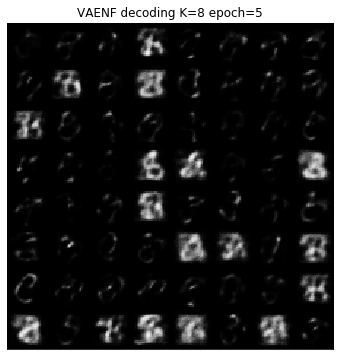

Train Epoch: 6 [0/60000 (0%)]	Loss: 91.275820
====> Epoch: 6 Average loss: 87.7254


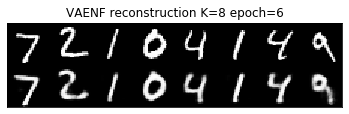

====> Test set loss: 96.3030


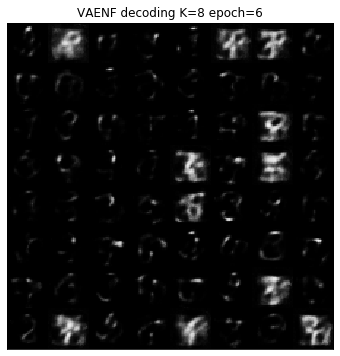

Train Epoch: 7 [0/60000 (0%)]	Loss: 93.648174
====> Epoch: 7 Average loss: 84.4862


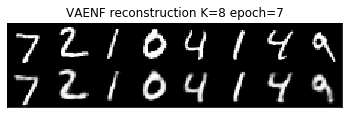

====> Test set loss: 85.3883


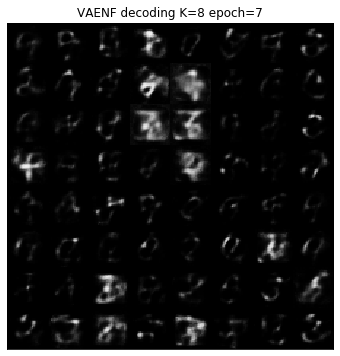

Train Epoch: 8 [0/60000 (0%)]	Loss: 84.287080
====> Epoch: 8 Average loss: 82.6683


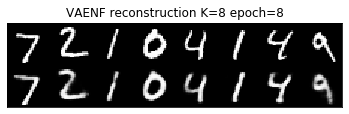

====> Test set loss: 85.8366


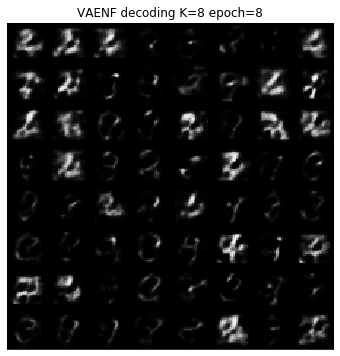

Train Epoch: 9 [0/60000 (0%)]	Loss: 83.779307
====> Epoch: 9 Average loss: 87.6402


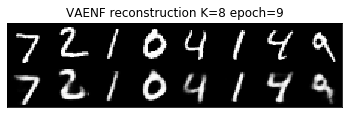

====> Test set loss: 88.8974


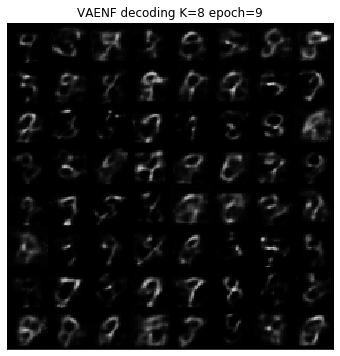

Train Epoch: 10 [0/60000 (0%)]	Loss: 84.537148
====> Epoch: 10 Average loss: 89.0019


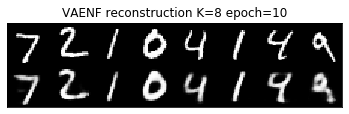

====> Test set loss: 91.4529


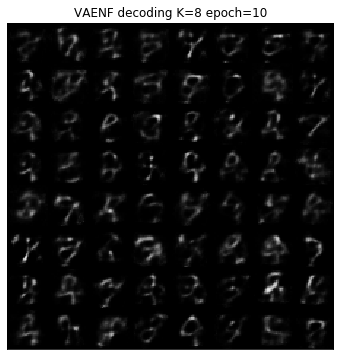

In [70]:
for epoch in range(1, 10 + 1):
    train_VAENF(epoch)
    test_VAENF(epoch)
    with torch.no_grad():
        _ , _, params = model.encode(large_batch.view(-1, 784))
        sample = torch.randn(64, 20).to(device)
        sample = model.decode( model.flow.forward( sample, params ) ).cpu()
        plot_image(sample.view(64, 1, 28, 28),
            'VAENF decoding K=' + str(model.flow.K) + " epoch=" + str(epoch), figsize=[6, 6], padding=0)

Train Epoch: 1 [100/60000 (0%)]	Loss: 525.306523
====> Epoch: 1 Average loss: 164.4784


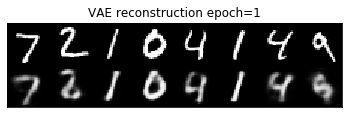

====> Test set loss: 130.2480


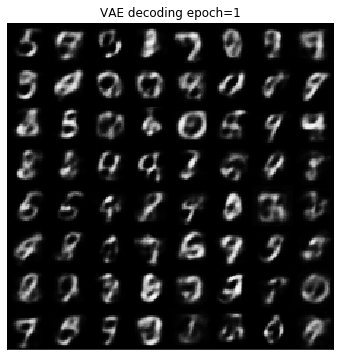

Train Epoch: 2 [100/60000 (0%)]	Loss: 130.031875
====> Epoch: 2 Average loss: 122.3364


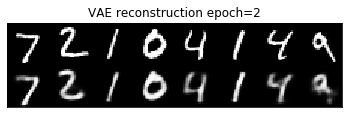

====> Test set loss: 117.0446


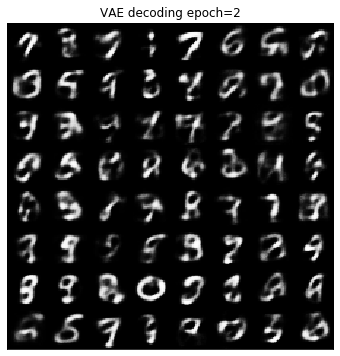

Train Epoch: 3 [100/60000 (0%)]	Loss: 117.403594
====> Epoch: 3 Average loss: 114.8553


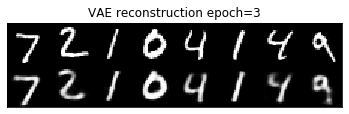

====> Test set loss: 112.4431


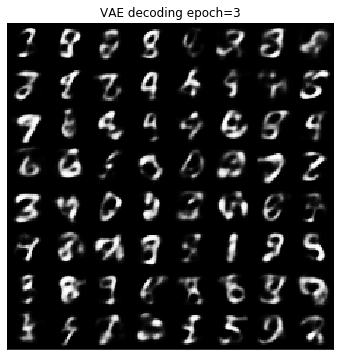

Train Epoch: 4 [100/60000 (0%)]	Loss: 112.560273
====> Epoch: 4 Average loss: 111.8208


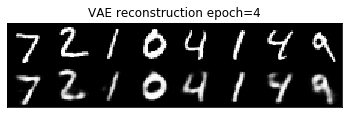

====> Test set loss: 110.5522


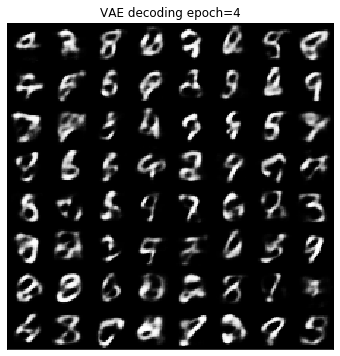

Train Epoch: 5 [100/60000 (0%)]	Loss: 110.954150
====> Epoch: 5 Average loss: 110.1025


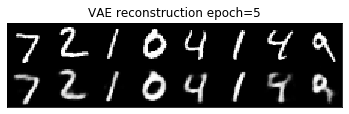

====> Test set loss: 109.1868


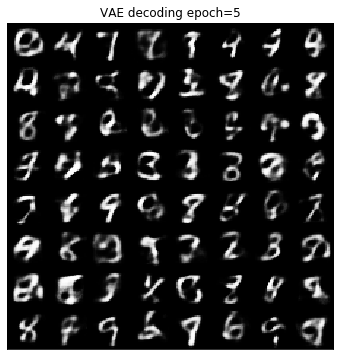

Train Epoch: 6 [100/60000 (0%)]	Loss: 108.154053
====> Epoch: 6 Average loss: 108.9609


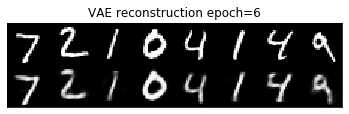

====> Test set loss: 108.2456


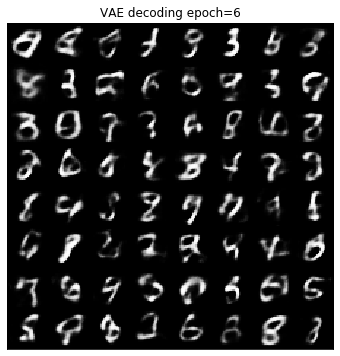

Train Epoch: 7 [100/60000 (0%)]	Loss: 107.044238
====> Epoch: 7 Average loss: 108.0557


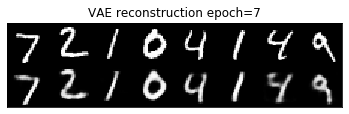

====> Test set loss: 107.2724


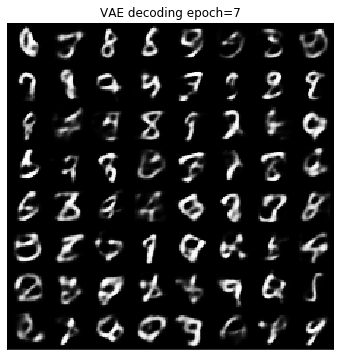

Train Epoch: 8 [100/60000 (0%)]	Loss: 105.679873
====> Epoch: 8 Average loss: 107.4208


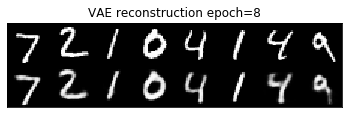

====> Test set loss: 106.8706


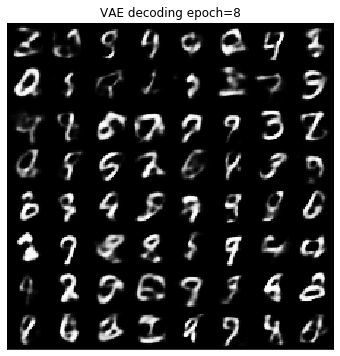

Train Epoch: 9 [100/60000 (0%)]	Loss: 105.214150
====> Epoch: 9 Average loss: 106.9007


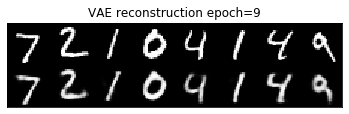

====> Test set loss: 106.8650


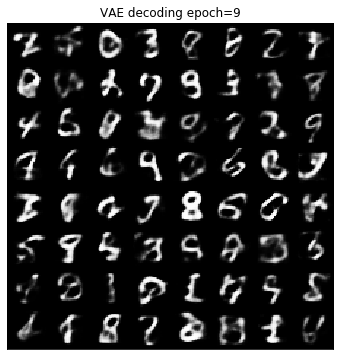

Train Epoch: 10 [100/60000 (0%)]	Loss: 105.196484
====> Epoch: 10 Average loss: 106.5015


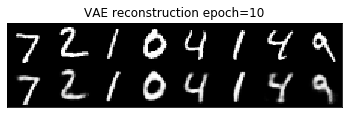

====> Test set loss: 106.5826


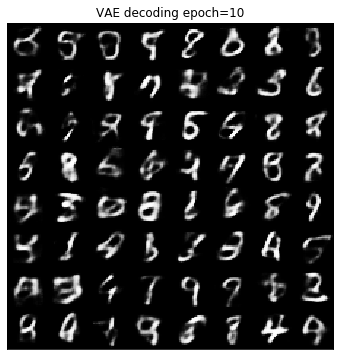

In [68]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 1000 == 1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(100, 1, 28, 28)[:n]])
                plot_image(comparison.cpu(),
                         'VAE reconstruction epoch=' + str(epoch), figsize=[6, 2], nrow=n, padding=0)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 10 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        plot_image(sample.view(64, 1, 28, 28),
        'VAE decoding epoch=' + str(epoch), figsize=[6, 6], padding=0)